# CS 189 Homework 5

### Name: Tony de Leon 
### SID: REDACTED

 I certify that all solutions are entirely in my own words and that I have not looked at another student’s solutions. I have given credit to all external sources I consulted.

To reproduce results, simply run all cells of this notebook in order

In [1]:
# built-in modules
import sys
from collections import Counter
import random

# third-party modules
import numpy as np
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from pydot import graph_from_dot_data
import io

RANDOM_SEED = 246810
MINIMUM = 5e-324 
# smallest value python can store, added to entropy to avoid -inf

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
RNG = np.random.default_rng(RANDOM_SEED)

eps = 1e-5

# Question 4: Decision Trees for Classification

## 4.1: Implement Decision Trees

In [293]:
# source: decision_tree_starter.py

class DecisionTree:

    def __init__(self, max_depth=3, parent=None, feature_labels=None, attribute_bag_size_calc=None):
        self.max_depth = max_depth
        self.features = feature_labels
        if parent == None:
            self.parent = self
        else:
            self.parent = parent # for non-root nodes, used in pruning
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        
        # Random Forest Variable
        self.m = attribute_bag_size_calc
        
        # Needed for visualize
        self._visualizing_ = True

    @staticmethod
    def entropy(y):
        probs = (np.bincount(y) / len(y))
        return np.sum(np.log2(probs + MINIMUM) * probs)
    
    def split(self, X, y):
        idx = self.split_idx
        thresh = self.thresh
        X0, idx0, X1, idx1 = self.split_test(X)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X):
        idx = self.split_idx
        thresh = self.thresh
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def fit(self, X, y):
        if self.max_depth == 0: # leaf
            self.data = np.bincount(y)
            if len(self.data) < 2:
                self.data = np.append(self.data, 0)
            self.pred = np.argmax(self.data)
            return self
        
        if len(np.unique(y)) < 2:
            self.max_depth = 0
            self.data = np.bincount(y)
            if len(self.data) < 2:
                self.data = np.append(self.data, 0)
            self.pred = np.argmax(self.data)
            return self
        
        best_feature_idx = 0
        best_threshold = 0
        min_H_after = float('inf')
        
        # training
        
        feature_indicies = range(X.shape[1])
        if self.m:
            feature_indicies = RNG.choice(X.shape[1], size = self.m(X), replace = False)
        
        for feature_idx in feature_indicies:
            feature_column = X[:, feature_idx]
            features_labeled_0 = feature_column[np.where(y == 0)]
            features_labeled_1 = feature_column[np.where(y == 1)]
            
            thresholds, counts = np.unique(feature_column, return_counts=True)
            thresholds0, counts0 = np.unique(features_labeled_0, return_counts=True)
            thresholds1, counts1 = np.unique(features_labeled_1, return_counts=True)
            thresholds = thresholds[1:] # never makes sense to use lowest number as threshold
            
            l_0 = 0
            l_1 = 0
            r_0 = features_labeled_0.size
            r_1 = features_labeled_1.size
            
            # np.unique sorted -> moving up the points in order
            for threshold in thresholds:
                if thresholds0.size and thresholds0[0] < threshold:
                    l_0 += counts0[0]
                    r_0 -= counts0[0]
                    thresholds0 = thresholds0[1:]
                    counts0 = counts0[1:]
                if thresholds1.size and thresholds1[0] < threshold:
                    l_1 += counts1[0]
                    r_1 -= counts1[0]
                    thresholds1 = thresholds1[1:]
                    counts1 = counts1[1:]
                    
                l_total = l_0 + l_1
                r_total = r_0 + r_1
                
                l_p0 = l_0 / l_total
                l_p1 = l_1 / l_total
                r_p0 = r_0 / r_total
                r_p1 = r_1 / r_total
                
                H_l = -(l_p0 * np.log2(l_p0 + MINIMUM) + l_p1 * np.log2(l_p1 + MINIMUM))
                H_r = -(r_p0 * np.log2(r_p0 + MINIMUM) + r_p1 * np.log2(r_p1 + MINIMUM))
                H_after = l_total * H_l + r_total * H_r
                
                if H_after < min_H_after:
                    min_H_after = H_after
                    best_feature_idx = feature_idx
                    best_threshold = threshold
        
        self.split_idx = best_feature_idx
        self.thresh = best_threshold
        
        idx_l = np.where(X[:, self.split_idx] < self.thresh)[0]
        X_l = X[idx_l]
        y_l = y[idx_l]
        self.left = DecisionTree(max_depth=self.max_depth - 1, 
                                 parent=self, 
                                 feature_labels=self.features)
        self.left.fit(X_l, y_l)
        
        idx_r = np.where(X[:, self.split_idx] >= self.thresh)[0]
        X_r = X[idx_r]
        y_r = y[idx_r]
        self.right = DecisionTree(max_depth=self.max_depth - 1, 
                                 parent=self, 
                                 feature_labels=self.features)
        self.right.fit(X_r, y_r)
        
        return self
        
    def prune(self, X_val, y_val):
        def is_leaf(node):
            return node.max_depth == 0
        parents_of_2_children = []
        stack = []
        stack.append(self)
        while stack:
            current_node = stack.pop()
            if is_leaf(current_node):
                continue
            if is_leaf(current_node.left):
                if is_leaf(current_node.right):
                    parents_of_2_children.append(current_node)
                else:
                    stack.append(current_node.right)
            else:
                stack.append(current_node.left)
                if not is_leaf(current_node.right):
                    stack.append(current_node.right)
                    
        def predict_and_store(node, X_val, y_val):
            if node.max_depth == 0:
                #node._visualizing_ = False
                storage = {id(node): y_val}
                #node._visualizing_ = True
                return storage
            X_l, y_l, X_r, y_r = node.split(X_val, y_val)
            l_dict = predict_and_store(node.left, X_l, y_l)
            r_dict = predict_and_store(node.right, X_r, y_r)
            l_dict.update(r_dict)
            return l_dict
        
        leaf_val_dict = predict_and_store(self, X_val, y_val)
                    
        while parents_of_2_children:
            p = parents_of_2_children.pop(0)
            #p.left._visualizing_ = False
            #p.right._visualizing_ = False
            l_val = leaf_val_dict.get(id(p.left), np.array([]))
            r_val = leaf_val_dict.get(id(p.right), np.array([]))
            #p.left._visualizing_ = True
            #p.right._visualizing_ = True
            tot_val = len(l_val) + len(r_val)
            
            agg_data = p.left.data + p.right.data
            agg_pred = np.argmax(agg_data)
            
            l_cor = np.count_nonzero(l_val == p.left.pred)
            r_cor = np.count_nonzero(r_val == p.right.pred)
            p_cor = np.count_nonzero(l_val == agg_pred) + np.count_nonzero(r_val == agg_pred)
            
            if l_cor + r_cor <= p_cor:
                p.data = agg_data
                p.pred = agg_pred
                p.max_depth = 0
                p.left = None
                p.right = None
                p.split_idx = None
                p.thresh = None
                p_val = np.append(l_val, r_val)
                leaf_val_dict[id(p)] = p_val
                if is_leaf(p.parent): # root becomes a leaf
                    continue
                if is_leaf(p.parent.left) and is_leaf(p.parent.right):
                    parents_of_2_children.append(p.parent)
        
        return self    
    
    def predict(self, X):
        if self.max_depth == 0:
            return self.pred + np.zeros(len(X), dtype = int)
        X_l, idx_l, X_r, idx_r = self.split_test(X)
        y = np.zeros(len(X))
        y[idx_l] = self.left.predict(X_l)
        y[idx_r] = self.right.predict(X_r)
        return y
    
    def verbose_spam_predict(self, Xi):
        if self.max_depth == 0:
            print(f"Therefore, this email was {'ham' if self.pred == 0 else 'spam'}")
        elif Xi[self.split_idx] < self.thresh:
            print(f'("{self.features[self.split_idx]}") < {self.thresh}')
            self.left.verbose_spam_predict(Xi)
        else:
            print(f'("{self.features[self.split_idx]}") >= {self.thresh}')
            self.right.verbose_spam_predict(Xi)
    def __repr__(self):
        #return "DecisionTree Node"
        if self._visualizing_:
            #self._visualizing_ = False
            return "DecisionTree Node"
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, sum(self.data))
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, 
                                           self.left.__repr__(),
                                           self.right.__repr__())

## scratch work, ignore

In [253]:
# uniform, max entropy possible. should be log2(n)
n = 1000000
test = np.arange(n)
bins = np.bincount(test)
print(bins)
n = len(test)
probs = bins / n
print(probs)
probs2 = probs # + MINIMUM #avoid -inf if 0, and does not affect calculations :)
print(sum(probs))
a = np.log2(probs) * probs
print(a)
print(sum(-a))
a2 = -sum(np.log2(probs2 + MINIMUM) * probs2)
print(a2)
print(np.log2(n))

[1 1 1 ... 1 1 1]
[1.e-06 1.e-06 1.e-06 ... 1.e-06 1.e-06 1.e-06]
1.000000000007918
[-1.99315686e-05 -1.99315686e-05 -1.99315686e-05 ... -1.99315686e-05
 -1.99315686e-05 -1.99315686e-05]
19.931568569559303
19.931568569559303
19.931568569324174


In [254]:
rng = np.random.default_rng(seed=RANDOM_SEED)
test = rng.choice(10, size = 99)
test = np.append(test, 12)
bins = np.bincount(test)
for i in enumerate(bins):
    print(i)
n = len(test)
probs = bins / n
print(probs)
#probs = probs + MINIMUM
print(sum(probs))
a = np.log2(probs + MINIMUM) * probs
print(a)
print(-sum(a))

(0, 8)
(1, 8)
(2, 12)
(3, 7)
(4, 12)
(5, 9)
(6, 17)
(7, 9)
(8, 8)
(9, 9)
(10, 0)
(11, 0)
(12, 1)
[0.08 0.08 0.12 0.07 0.12 0.09 0.17 0.09 0.08 0.09 0.   0.   0.01]
1.0
[-0.2915085  -0.2915085  -0.36706724 -0.26855509 -0.36706724 -0.31265381
 -0.43458687 -0.31265381 -0.2915085  -0.31265381 -0.         -0.
 -0.06643856]
3.316201911655633


In [255]:
test_X = np.append(np.random.normal(loc = 0, scale = 0.1, size = 100), np.random.normal(loc = 1, scale = 0.1, size = 100)).reshape((200, 1))
test_X = np.hstack((test_X, np.ones(200).reshape((200,1))))
test_y = np.append(np.zeros(100, dtype=int), np.ones(100, dtype = int))
test = DecisionTree(feature_labels=["gaussian mean","one"])
test.fit(test_X, test_y)
test

DecisionTree Node

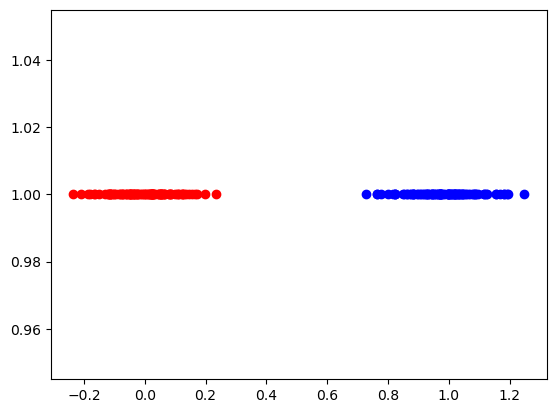

In [256]:
plt.scatter(test_X[:100, 0], np.ones(100), color ="red")
plt.scatter(test_X[100:, 0], np.ones(100), color ="blue")

In [257]:
print(test.split_idx, test.thresh)
print(test_X[np.where(test_X[:, 0] < test.thresh)].shape)
print(test.left.split_idx, test.left.max_depth)
print(test.right.split_idx, test.right.max_depth)

0 0.7290377973656419
(100, 2)
None 0
None 0


## 4.2: Implement a Random Forest

In [258]:
# source: decision_tree_starter.py

class BaggedTrees:

    def __init__(self, params=None, max_depth=3, feature_labels=None, num_trees=200, sample_prop=1):
        if params is None:
            params = {
                "max_depth": max_depth,
                "feature_labels": feature_labels,
            }
        self.params = params
        self.n = num_trees
        self.sample_prop = sample_prop
        self.decision_trees = [DecisionTree(**self.params) for _ in range(self.n)]

    def fit(self, X, y):
            
        for tree in self.decision_trees:
            sample_idxs = RNG.choice(len(y), size = self.sample_prop * len(y), replace=True)
            X_sample = X[sample_idxs]
            y_sample = y[sample_idxs]
            tree.fit(X_sample, y_sample)
            
    def prune(self, X_val, y_val):
        for tree in self.decision_trees:
            tree.prune(X_val, y_val)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        
        for tree in self.decision_trees:
            predictions = predictions + tree.predict(X)
            
        predicitions = (predictions >= (len(self.decision_trees) / 2)).astype(int)
        return predictions

class RandomForest(BaggedTrees):

    def __init__(self, max_depth=3, feature_labels=None, 
                 num_trees=200, sample_prop=1, attribute_bag_size_calc=lambda x:1):
        params = {
            "max_depth": max_depth,
            "feature_labels": feature_labels,
            "attribute_bag_size_calc": attribute_bag_size_calc
        }
        super().__init__(params=params, num_trees=num_trees, sample_prop=sample_prop)

## 4.4: Performance Evaluation

In [259]:
# to install rcviz
# !pip install git+https://github.com/carlsborg/rcviz.git#egg=rcviz
from rcviz import viz, callgraph

In [260]:
@viz
def visualize(tree):
    if tree.max_depth == 0:
        classification = tree.pred
        visualize.track(classification=classification)
    else:
        feature = tree.features[tree.split_idx]
        #print(feature)
        split_rule = tree.thresh
        visualize.track(feature=feature)
        visualize.track(split_rule=split_rule)
        
        tree.left._visualizing_ = True
        tree.right._visualizing_ = True
        #print(tree.left._visualizing_)
        #print(tree.right._visualizing_)
        
        visualize(tree.left)
        visualize(tree.right)

In [261]:
# source: decision_tree_starter.py

def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack(
        [np.array(data, dtype=float),
         np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        # TODO
        pass

    return data, onehot_features

In [262]:
def train_val_split(X, y, val_prop=0.2):
    shuffle = RNG.choice(len(y), size=len(y), replace=False)
    X = X[shuffle]
    y = y[shuffle]
    
    rand_idxs = RNG.choice(len(y), size=round(len(y) * val_prop), replace=False)
    y_val = y[rand_idxs]
    X_val = X[rand_idxs]
    y_train = np.delete(y, rand_idxs)
    X_train = np.delete(X, rand_idxs, axis = 0)
    
    return X_train, y_train, X_val, y_val

In [263]:
# Spam
spam_features = [
    "pain", "private", "bank", "money", "drug", "spam", "prescription",
    "creative", "height", "featured", "differ", "width", "other",
    "energy", "business", "message", "volumes", "revision", "path",
    "meter", "memo", "planning", "pleased", "record", "out",
    "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
    "square_bracket", "ampersand"
]

assert len(spam_features) == 32

# Load spam data
path_train = 'datasets/spam_data/spam_data.mat'
data = scipy.io.loadmat(path_train)
spam_X = data['training_data']
spam_y = np.squeeze(data['training_labels']).astype(int)
spam_Z = data['test_data']
spam_class_names = ["Ham", "Spam"]

print("Features", spam_features)
print("Train/test size", spam_X.shape, spam_Z.shape)

print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - np.sum(spam_y) / spam_y.size)

RNG = np.random.default_rng(seed=RANDOM_SEED + 2)

spam_X_train, spam_y_train, spam_X_val, spam_y_val = train_val_split(spam_X, spam_y)

print("\nTrain size", spam_X_train.shape, spam_y_train.shape)
print("Val size", spam_X_val.shape, spam_y_val.shape)

Features ['pain', 'private', 'bank', 'money', 'drug', 'spam', 'prescription', 'creative', 'height', 'featured', 'differ', 'width', 'other', 'energy', 'business', 'message', 'volumes', 'revision', 'path', 'meter', 'memo', 'planning', 'pleased', 'record', 'out', 'semicolon', 'dollar', 'sharp', 'exclamation', 'parenthesis', 'square_bracket', 'ampersand']
Train/test size (5629, 32) (5400, 32)


Part 0: constant classifier
Accuracy 0.7258838159531

Train size (4503, 32) (4503,)
Val size (1126, 32) (1126,)


In [264]:
# Titanic

# Load titanic data
path_train = 'datasets/titanic/titanic_training.csv'
data = genfromtxt(path_train, delimiter=',', dtype=None)
path_test = 'datasets/titanic/titanic_testing_data.csv'
test_data = genfromtxt(path_test, delimiter=',', dtype=None)
y = data[1:, 0]  # label = survived
titanic_class_names = ["Died", "Survived"]

labeled_idx = np.where(y != b'')[0]
titanic_y = np.array(y[labeled_idx], dtype=float).astype(int)
print("\n\nPart (b): preprocessing the titanic dataset")
titanic_X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
titanic_X = titanic_X[labeled_idx, :]
titanic_Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
assert titanic_X.shape[1] == titanic_Z.shape[1]
titanic_features = list(data[0, 1:]) + onehot_features

print("Features", titanic_features)
print("Train/test size", titanic_X.shape, titanic_Z.shape)

print("\n\nPart 0: constant classifier")
print("Accuracy", 1 - np.sum(titanic_y) / titanic_y.size)

RNG = np.random.default_rng(seed=RANDOM_SEED + 1)

titanic_X_train, titanic_y_train, titanic_X_val, titanic_y_val = train_val_split(titanic_X, titanic_y)

print("\nTrain size", titanic_X_train.shape, titanic_y_train.shape)
print("Val size", titanic_X_val.shape, titanic_y_val.shape)



Part (b): preprocessing the titanic dataset
Features [b'pclass', b'sex', b'age', b'sibsp', b'parch', b'ticket', b'fare', b'cabin', b'embarked', b'male', b'female', b'S', b'C', b'Q']
Train/test size (1009, 14) (300, 14)


Part 0: constant classifier
Accuracy 0.6194251734390486

Train size (807, 14) (807,)
Val size (202, 14) (202,)


/var/folders/vs/j4s8bcls5tjd06_jm45rmzdr0000gn/T/ipykernel_5743/3761426322.py:5: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = genfromtxt(path_train, delimiter=',', dtype=None)
/var/folders/vs/j4s8bcls5tjd06_jm45rmzdr0000gn/T/ipykernel_5743/3761426322.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  test_data = genfromtxt(path_test, delimiter=',', dtype=None)


In [305]:
titanic_X[1:5], titanic_features

(array([[  1.    ,   0.    ,  23.    ,   1.    ,   0.    ,   0.    ,
         113.275 ,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ,
           1.    ,   0.    ],
        [  3.    ,   0.    ,  38.    ,   0.    ,   0.    ,   0.    ,
           7.05  ,   0.    ,   0.    ,   0.    ,   0.    ,   1.    ,
           0.    ,   0.    ],
        [  2.    ,   0.    ,  -1.    ,   0.    ,   0.    ,   0.    ,
          15.5792,   0.    ,   0.    ,   1.    ,   0.    ,   0.    ,
           1.    ,   0.    ],
        [  3.    ,   0.    ,  -1.    ,   0.    ,   0.    ,   0.    ,
           7.8958,   0.    ,   0.    ,   0.    ,   0.    ,   1.    ,
           0.    ,   0.    ]]),
 [b'pclass',
  b'sex',
  b'age',
  b'sibsp',
  b'parch',
  b'ticket',
  b'fare',
  b'cabin',
  b'embarked',
  b'male',
  b'female',
  b'S',
  b'C',
  b'Q'])

In [267]:
### UNCOMMENT TO RUN IF DESIRED ###

# RNG = np.random.default_rng(seed=RANDOM_SEED)

# DecisionTree_params = {
#     "max_depth": 20,
#     # "feature_labels": features,
# }

# RandomForest_params = {
#     "max_depth": 20,
#     # "feature_labels": features,
#     "num_trees": 100,
#     "sample_prop": 1,
#     "attribute_bag_size_calc": lambda X: round(np.sqrt(X.shape[1]))
# }

# data = [
#     ("Spam", 
#      spam_X_train, spam_y_train, 
#      spam_X_val, spam_y_val, 
#      spam_features, spam_class_names),
#     ("Titanic", 
#      titanic_X_train, titanic_y_train, 
#      titanic_X_val, titanic_y_val, 
#      titanic_features, titanic_class_names)
# ]
# classifiers = [
#     ("DecisionTree", DecisionTree_params),
#     ("RandomForest", RandomForest_params)
# ]

# for dataset, X_train, y_train, X_val, y_val, features, class_names in data:
#     DecisionTree_params["feature_labels"] = features
#     RandomForest_params["feature_labels"] = features
#     print("Dataset:", dataset)
#     print("___________________________________")
#     for classifier, params in classifiers:
#         print("Classifier:", classifier)
#         classifier_obj = eval(classifier)
#         model = classifier_obj(**params)
#         model.fit(X_train, y_train)
        
#         train_pred = model.predict(X_train)
#         val_pred = model.predict(X_val)
        
#         print("Prepruning Train acc:", np.count_nonzero(train_pred == y_train) / len(y_train))
#         print("Prepruning Val acc", np.count_nonzero(val_pred == y_val) / len(y_val))
        
#         model.prune(X_val, y_val)
        
#         train_pred = model.predict(X_train)
#         val_pred = model.predict(X_val)
        
#         print("Pruned Train acc:", np.count_nonzero(train_pred == y_train) / len(y_train))
#         print("Pruned Val acc", np.count_nonzero(val_pred == y_val) / len(y_val))
#         print()
#     print("___________________________________")
#     print()

Dataset: Spam
___________________________________
Classifier: DecisionTree
Prepruning Train acc: 0.8856318010215412
Prepruning Val acc 0.8126110124333925
Pruned Train acc: 0.8612036420164335
Pruned Val acc 0.8259325044404974

Classifier: RandomForest
Prepruning Train acc: 0.48945147679324896
Prepruning Val acc 0.4502664298401421
Pruned Train acc: 0.5380857206306906
Pruned Val acc 0.5079928952042628

___________________________________

Dataset: Titanic
___________________________________
Classifier: DecisionTree
Prepruning Train acc: 0.9789343246592317
Prepruning Val acc 0.7326732673267327
Pruned Train acc: 0.8872366790582404
Pruned Val acc 0.8267326732673267

Classifier: RandomForest
Prepruning Train acc: 0.11400247831474597
Prepruning Val acc 0.06930693069306931
Pruned Train acc: 0.14993804213135067
Pruned Val acc 0.09900990099009901

___________________________________



In [268]:
# Decision Trees Seem Generally better,
# but perhaps a RandomForest with fewer trees would be better

# hyperparameters to tune: 
# num_trees
# sample_size
# attribute_bag_size
# max_depth

In [270]:
RandomForest_params = {
    "max_depth": 20,
    # "feature_labels": features,
    "num_trees": 100,
    "sample_prop": 1,
    "attribute_bag_size_calc": lambda X: round(np.sqrt(X.shape[1]))
}

def hyperparameter_tuning(hyperparameter, values, 
                          default_params=RandomForest_params, classifier=RandomForest,
                         verbose = True, dataset=None):
    RNG = np.random.default_rng(seed=RANDOM_SEED)

    if verbose:
        print(default_params)
        print()
        print("___________________________________")
        print()

    
    data = [
        ("Spam", 
         spam_X_train, spam_y_train, 
         spam_X_val, spam_y_val, 
         spam_features, spam_class_names),
        ("Titanic", 
         titanic_X_train, titanic_y_train, 
         titanic_X_val, titanic_y_val, 
         titanic_features, titanic_class_names)
    ]
    
    if dataset:
        if dataset == "titanic":
            data = [data[1]]
        else:
            data = [data[0]]

    preprune_train_accs = []
    preprune_val_accs = []
    pruned_train_accs = []
    pruned_val_accs = []
    
    for dataset, X_train, y_train, X_val, y_val, features, class_names in data:
        default_params["feature_labels"] = features
        if verbose:
            print("Dataset:", dataset)
            print("___________________________________")
        for value in values:
            default_params[hyperparameter] = value
            
            model = classifier(**default_params)
            model.fit(X_train, y_train)

            train_pred1 = model.predict(X_train)
            val_pred1 = model.predict(X_val)
            train_acc1 = np.count_nonzero(train_pred1 == y_train) / len(y_train)
            val_acc1 = np.count_nonzero(val_pred1 == y_val) / len(y_val)
            preprune_train_accs.append(train_acc1)
            preprune_val_accs.append(val_acc1)

            model.prune(X_val, y_val)

            train_pred2 = model.predict(X_train)
            val_pred2 = model.predict(X_val)
            train_acc2 = np.count_nonzero(train_pred2 == y_train) / len(y_train)
            val_acc2 = np.count_nonzero(val_pred2 == y_val) / len(y_val)
            pruned_train_accs.append(train_acc2)
            pruned_val_accs.append(val_acc2)

            if verbose:
                print(f"{hyperparameter} value =", default_params[hyperparameter])
                print("Prepruning Train acc:", train_acc1)
                print("Prepruning Val_acc", val_acc1)
                print("Pruned Train acc:", train_acc2)
                print("Pruned Val_acc", val_acc2)
                print()
        if verbose:
            print("___________________________________")
            print()
    return preprune_train_accs, preprune_val_accs, pruned_train_accs, pruned_val_accs

In [271]:
## UNCOMMENT TO RUN IF DESIRED ###

# hyperparameter = "num_trees"
# values = [1, 2, 3, 5, 10, 50]
# hyperparameter_tuning(hyperparameter, values)

{'max_depth': 20, 'num_trees': 100, 'sample_prop': 1, 'attribute_bag_size_calc': <function <lambda> at 0x148b0e0c0>}

___________________________________

Dataset: Spam
___________________________________
num_trees value = 1
Prepruning Train acc: 0.866089273817455
Prepruning Val_acc 0.8019538188277087
Pruned Train acc: 0.8532089717965801
Pruned Val_acc 0.8197158081705151

num_trees value = 2
Prepruning Train acc: 0.6955363091272485
Prepruning Val_acc 0.6705150976909414
Pruned Train acc: 0.6946480124361537
Pruned Val_acc 0.6865008880994672

num_trees value = 3
Prepruning Train acc: 0.6582278481012658
Prepruning Val_acc 0.6234458259325044
Pruned Train acc: 0.664890073284477
Pruned Val_acc 0.650088809946714

num_trees value = 5
Prepruning Train acc: 0.6329113924050633
Prepruning Val_acc 0.5905861456483126
Pruned Train acc: 0.6475682878081279
Pruned Val_acc 0.6341030195381883

num_trees value = 10
Prepruning Train acc: 0.6020430823895181
Prepruning Val_acc 0.5506216696269982
Pruned Train a

([0.866089273817455,
  0.6955363091272485,
  0.6582278481012658,
  0.6329113924050633,
  0.6020430823895181,
  0.524983344437042,
  0.8909541511771994,
  0.6319702602230484,
  0.5315985130111525,
  0.4448574969021066,
  0.3593556381660471,
  0.19950433705080545],
 [0.8019538188277087,
  0.6705150976909414,
  0.6234458259325044,
  0.5905861456483126,
  0.5506216696269982,
  0.46625222024866786,
  0.7524752475247525,
  0.41089108910891087,
  0.3811881188118812,
  0.29207920792079206,
  0.2079207920792079,
  0.10396039603960396],
 [0.8532089717965801,
  0.6946480124361537,
  0.664890073284477,
  0.6475682878081279,
  0.6273595380857206,
  0.562069731290251,
  0.8562577447335812,
  0.6183395291201983,
  0.5291201982651796,
  0.49318463444857497,
  0.38166047087980176,
  0.24039653035935563],
 [0.8197158081705151,
  0.6865008880994672,
  0.650088809946714,
  0.6341030195381883,
  0.6074600355239786,
  0.5364120781527532,
  0.8118811881188119,
  0.5198019801980198,
  0.44554455445544555,
  0

In [272]:
# I have decided RandomForests simply suck :)

In [285]:
hyperparameter = "max_depth"
values = np.arange(1, 41)

(unpruned_train_accs, 
 unpruned_val_accs, 
 pruned_train_accs, 
 pruned_val_accs) = hyperparameter_tuning(hyperparameter, values, 
                      default_params = {}, classifier=DecisionTree, 
                      verbose = False, dataset="spam")

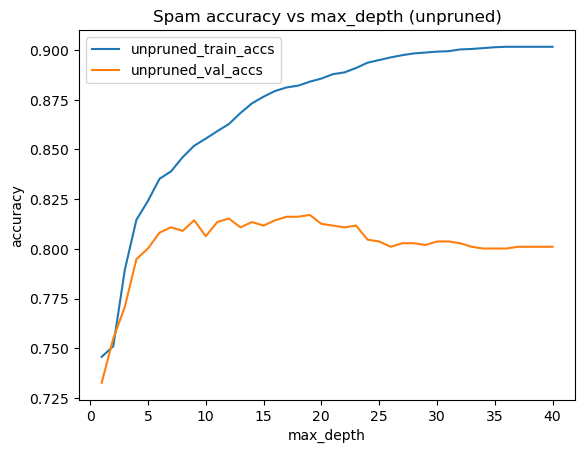

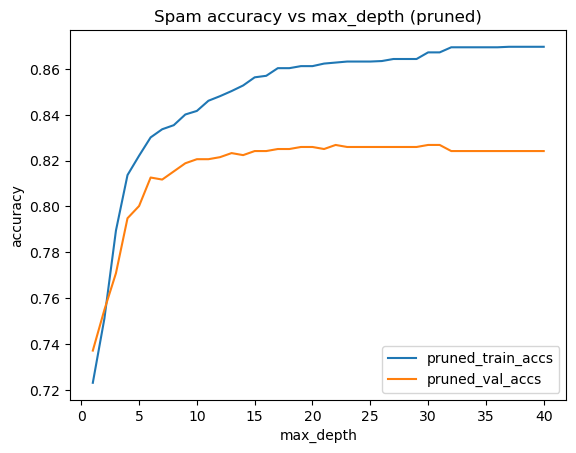

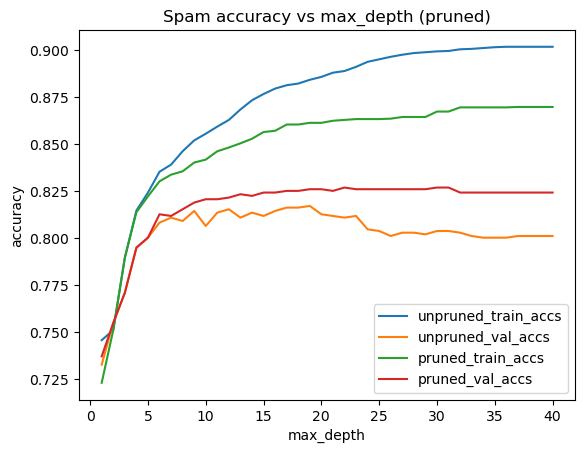

In [286]:
plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.title("Spam accuracy vs max_depth (unpruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Spam accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Spam accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [288]:
best = np.argmax(pruned_val_accs)
best, pruned_val_accs[best]

(21, 0.8268206039076377)

In [289]:
best = np.argmax(unpruned_val_accs)
best, unpruned_val_accs[best]

(18, 0.8170515097690941)

In [277]:
hyperparameter = "max_depth"
values = np.arange(1, 41)

(unpruned_train_accs, 
 unpruned_val_accs, 
 pruned_train_accs, 
 pruned_val_accs) = hyperparameter_tuning(hyperparameter, values, 
                      default_params = {}, classifier=DecisionTree, 
                      verbose = False, dataset="titanic")

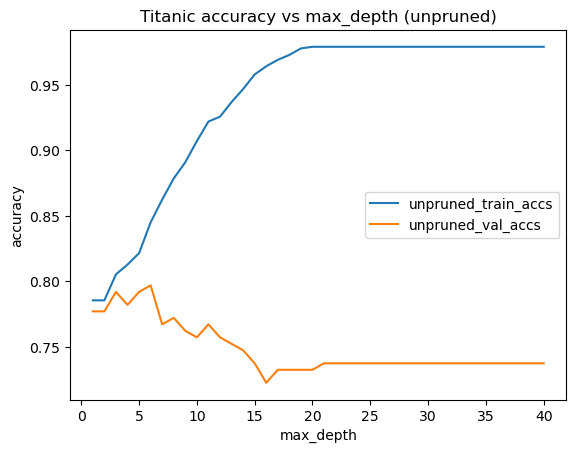

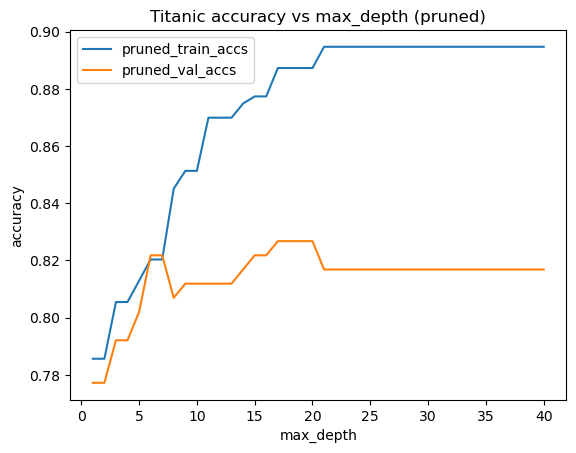

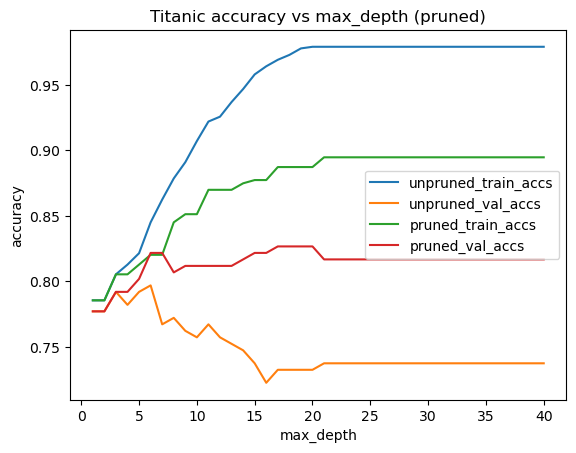

In [284]:
plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.title("Titanic accuracy vs max_depth (unpruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Titanic accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Titanic accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [279]:
best = np.argmax(pruned_val_accs)
best, pruned_val_accs[best]

(16, 0.8267326732673267)

In [280]:
best = np.argmax(unpruned_val_accs)
best, unpruned_val_accs[best]

(5, 0.7970297029702971)

In [296]:
RNG = np.random.default_rng(seed=RANDOM_SEED)

spam_Kaggle_model = DecisionTree(max_depth=21, feature_labels=spam_features)
spam_Kaggle_model.fit(spam_X_train, spam_y_train)

spam_train_preds = spam_Kaggle_model.predict(spam_X_train)
print("unpruned train acc:", np.count_nonzero(spam_train_preds == spam_y_train) / len(spam_y_train))

spam_Kaggle_model.prune(spam_X_val, spam_y_val)

spam_train_preds = spam_Kaggle_model.predict(spam_X_train)
print("pruned train acc:", np.count_nonzero(spam_train_preds == spam_y_train) / len(spam_y_train))

spam_Kaggle_preds = spam_Kaggle_model.predict(spam_Z).astype(int)
df = pd.DataFrame({'Category': spam_Kaggle_preds})
df.index += 1
df.to_csv("Spam_submission_1.csv", index_label='Id')

unpruned train acc: 0.8878525427492783
pruned train acc: 0.8623140128803021


In [290]:
RNG = np.random.default_rng(seed=RANDOM_SEED)

titanic_Kaggle_model = DecisionTree(max_depth=16, feature_labels=titanic_features)
titanic_Kaggle_model.fit(titanic_X_train, titanic_y_train)

titanic_train_preds = titanic_Kaggle_model.predict(titanic_X_train)
print("train acc:", np.count_nonzero(titanic_train_preds == titanic_y_train) / len(titanic_y_train))

titanic_Kaggle_model.prune(titanic_X_val, titanic_y_val)

titanic_train_preds = titanic_Kaggle_model.predict(titanic_X_train)
print("train acc:", np.count_nonzero(titanic_train_preds == titanic_y_train) / len(titanic_y_train))

titanic_Kaggle_preds = titanic_Kaggle_model.predict(titanic_Z).astype(int)
df = pd.DataFrame({'Category': titanic_Kaggle_preds})
df.index += 1
df.to_csv("Titanic_submission_1.csv", index_label='Id')

train acc: 0.9640644361833953
train acc: 0.8773234200743495


## 4.5: Writeup Requirements for the Spam Dataset 

In [297]:
for i in range(3):
    spam_Kaggle_model.verbose_spam_predict(spam_X[i])
    print()

("exclamation") < 1.0
("parenthesis") < 1.0
("meter") < 1.0
("creative") < 1.0
("money") >= 1.0
("business") >= 1.0
Therefore, this email was spam

("exclamation") < 1.0
("parenthesis") >= 1.0
("money") < 1.0
("featured") < 1.0
("energy") < 1.0
("dollar") < 2.0
("message") < 1.0
Therefore, this email was ham

("exclamation") >= 1.0
("money") < 1.0
("parenthesis") >= 1.0
("dollar") < 2.0
("exclamation") < 3.0
("parenthesis") < 2.0
("business") < 1.0
("meter") < 1.0
("path") < 1.0
("square_bracket") < 1.0
("pain") < 1.0
("bank") < 1.0
Therefore, this email was ham



In [285]:
hyperparameter = "max_depth"
values = np.arange(1, 41)

(unpruned_train_accs, 
 unpruned_val_accs, 
 pruned_train_accs, 
 pruned_val_accs) = hyperparameter_tuning(hyperparameter, values, 
                      default_params = {}, classifier=DecisionTree, 
                      verbose = False, dataset="spam")

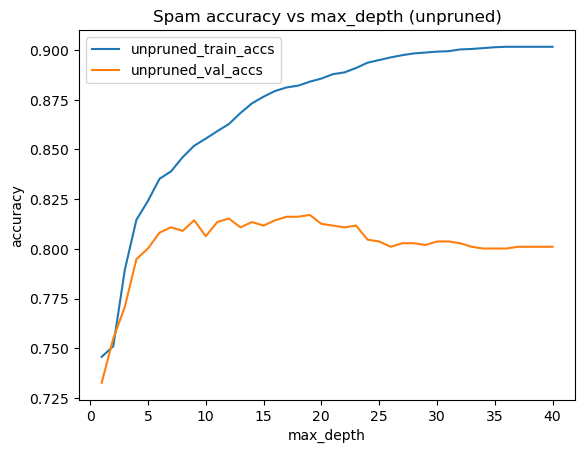

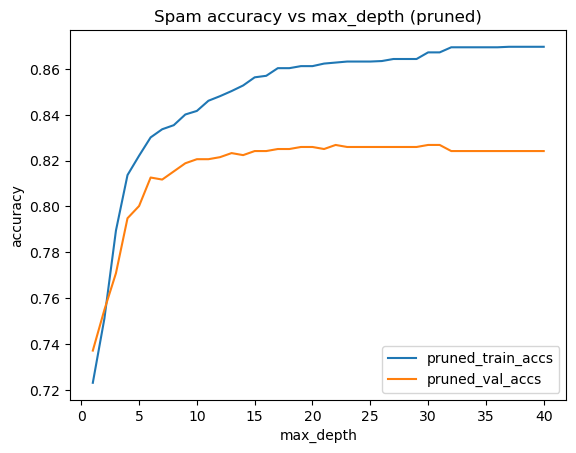

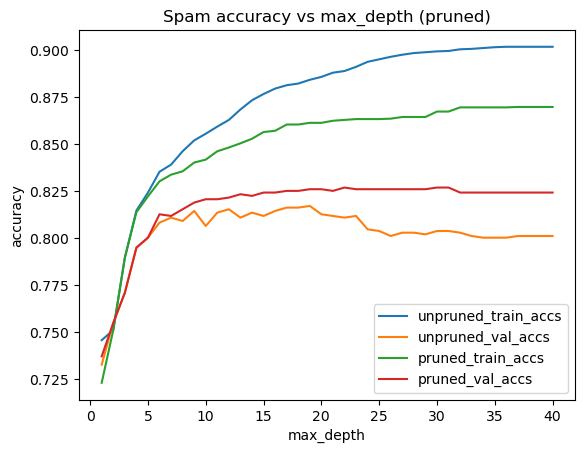

In [286]:
plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.title("Spam accuracy vs max_depth (unpruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Spam accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(values, unpruned_train_accs, label="unpruned_train_accs")
plt.plot(values, unpruned_val_accs, label="unpruned_val_accs")
plt.plot(values, pruned_train_accs, label="pruned_train_accs")
plt.plot(values, pruned_val_accs, label="pruned_val_accs")
plt.title("Spam accuracy vs max_depth (pruned)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## 4.6: Writeup Requirements for the Titanic Dataset 

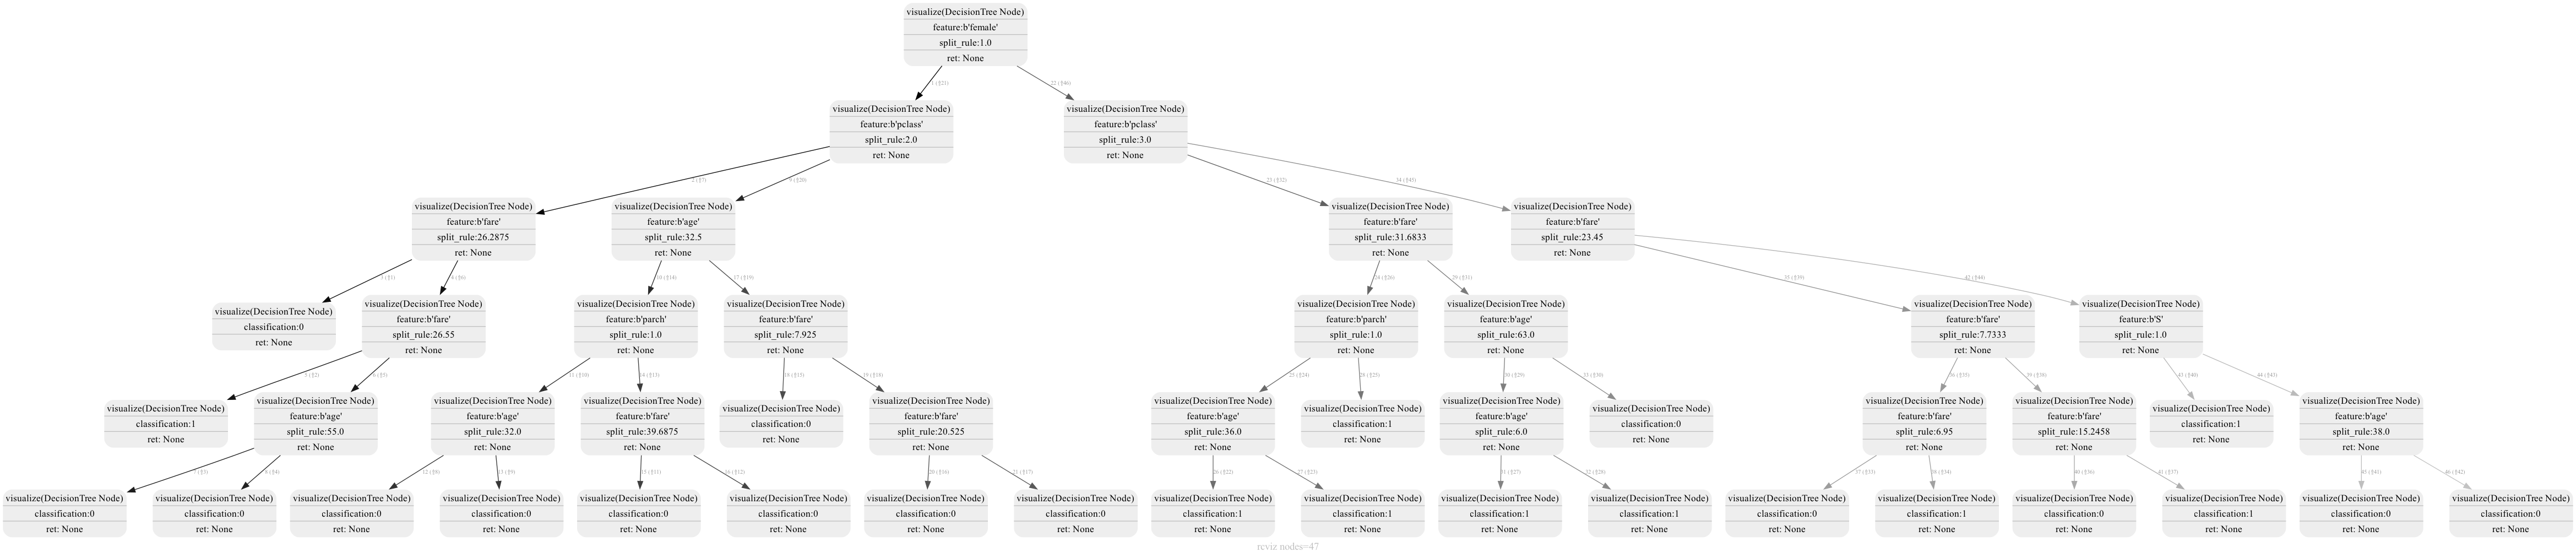

In [300]:
callgraph.reset()
model = DecisionTree(max_depth = 5, feature_labels=titanic_features)
model.fit(titanic_X_train, titanic_y_train)
visualize(model)
callgraph.render()

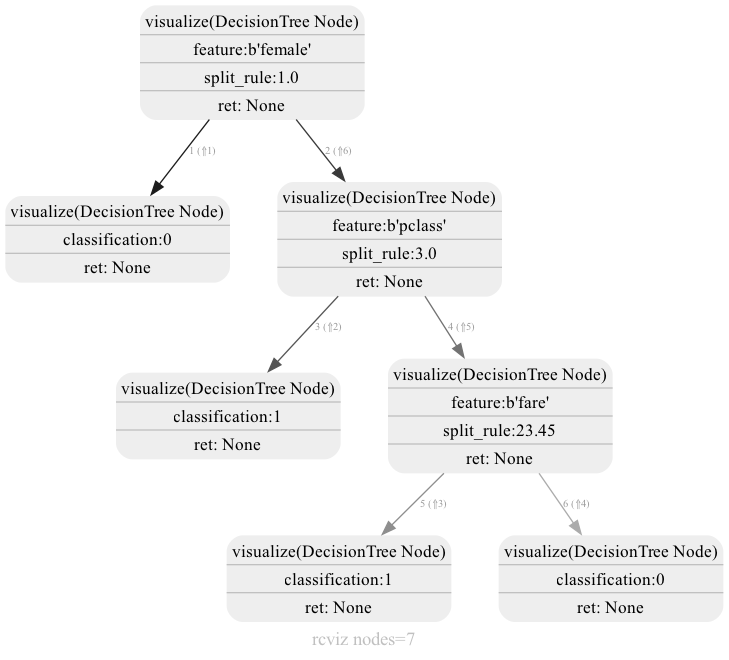

In [301]:
callgraph.reset()
model.prune(titanic_X_val, titanic_y_train)
visualize(model)
callgraph.render()